Loaded model from rcnn3/residual_cnn_snake_model_6800.pth
Episode: 6801/7500, Score: -53, Steps: 44
Episode: 6802/7500, Score: -81, Steps: 105
Episode: 6803/7500, Score: -25, Steps: 16
Episode: 6804/7500, Score: -7, Steps: 20
Episode: 6805/7500, Score: -32, Steps: 45
Episode: 6806/7500, Score: -82, Steps: 84
Episode: 6807/7500, Score: -21, Steps: 23
Episode: 6808/7500, Score: -39, Steps: 63
Episode: 6809/7500, Score: -18, Steps: 20
Episode: 6810/7500, Score: -45, Steps: 36
Episode: 6811/7500, Score: 1, Steps: 12
Episode: 6812/7500, Score: -6, Steps: 19
Episode: 6813/7500, Score: -28, Steps: 41
Episode: 6814/7500, Score: -21, Steps: 34
Episode: 6815/7500, Score: -12, Steps: 14
Episode: 6816/7500, Score: -14, Steps: 27
Episode: 6817/7500, Score: -58, Steps: 60
Episode: 6818/7500, Score: -8, Steps: 10
Episode: 6819/7500, Score: -21, Steps: 12
Episode: 6820/7500, Score: -32, Steps: 23
Episode: 6821/7500, Score: -19, Steps: 32
Episode: 6822/7500, Score: -15, Steps: 17
Episode: 6823/7500, Sc

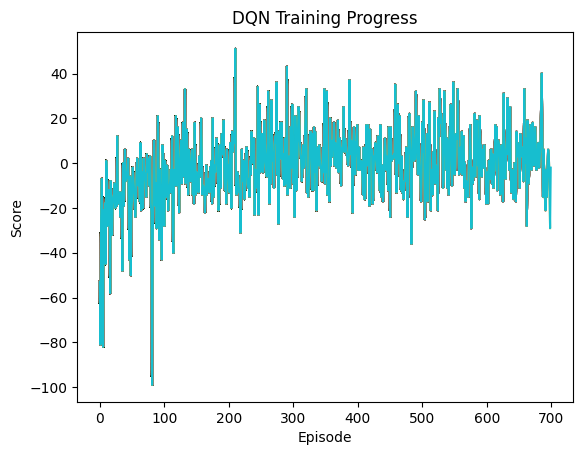

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np
import time
import pygame
import matplotlib.pyplot as plt
import csv
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResidualCNN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(ResidualCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(32, 32, 2)
        self.layer2 = self._make_layer(32, 64, 2)
        self.fc1 = nn.Linear(384, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, action_dim)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out

class DQNAgent:
    def __init__(self, input_dim, action_dim):
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = ResidualCNN(input_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)  # Reshape to [1, 1, 6, 1]
        with torch.no_grad():
            action_values = self.model(state)
        return torch.argmax(action_values[0]).item()

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)  # Ensure batch and channel dimensions
            next_state = torch.FloatTensor(next_state).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)  # Ensure batch and channel dimensions
            target = reward
            if not done:
                target = (reward + self.gamma * torch.max(self.model(next_state)[0])).item()
            target_f = self.model(state)
            target_f[0][action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(target_f, self.model(state))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

class SnakeGameAI:
    def __init__(self, width=240, height=240, snake_size=20):
        self.width = width
        self.height = height
        self.snake_size = snake_size
        self.reset()

    def reset(self):
        self.x1 = self.width / 2
        self.y1 = self.height / 2
        self.x1_change = 0
        self.y1_change = 0
        self.snake_List = []
        self.Length_of_snake = 1
        self.foodx = round(random.randrange(0, self.width - self.snake_size) / self.snake_size) * self.snake_size
        self.foody = round(random.randrange(0, self.height - self.snake_size) / self.snake_size) * self.snake_size
        self.score = 0
        return self.get_state()

    def step(self, action):
        if action == 0:  # LEFT
            self.x1_change = -self.snake_size
            self.y1_change = 0
        elif action == 1:  # RIGHT
            self.x1_change = self.snake_size
            self.y1_change = 0
        elif action == 2:  # UP
            self.y1_change = -self.snake_size
            self.x1_change = 0
        elif action == 3:  # DOWN
            self.y1_change = self.snake_size
            self.x1_change = 0

        self.x1 += self.x1_change
        self.y1 += self.y1_change

        done = self.x1 >= self.width or self.x1 < 0 or self.y1 >= self.height or self.y1 < 0
        snake_Head = [self.x1, self.y1]
        self.snake_List.append(snake_Head)
        if len(self.snake_List) > self.Length_of_snake:
            del self.snake_List[0]

        for x in self.snake_List[:-1]:
            if x == snake_Head:
                done = True

        reward = -1  # Small negative reward for each step
        if self.x1 == self.foodx and self.y1 == self.foody:
            self.foodx = round(random.randrange(0, self.width - self.snake_size) / self.snake_size) * self.snake_size
            self.foody = round(random.randrange(0, self.height - self.snake_size) / self.snake_size) * self.snake_size
            self.Length_of_snake += 1
            reward = 10
            self.score += 1

        if done:
            reward = -10  # Negative reward for dying

        state = self.get_state()
        return state, reward, done

    def get_state(self):
        state = [
            self.x1, self.y1, self.foodx, self.foody,
            self.x1_change, self.y1_change,
        ]
        return np.array(state, dtype=np.float32)

    def render(self):
        window = pygame.display.set_mode((self.width, self.height))
        window.fill((0, 0, 0))
        for segment in self.snake_List:
            pygame.draw.rect(window, (0, 255, 0), [segment[0], segment[1], self.snake_size, self.snake_size])
        pygame.draw.rect(window, (255, 255, 255), [self.foodx, self.foody, self.snake_size, self.snake_size])
        pygame.display.update()

def train_until_achieve_score(target_score=10, load_path=None, episode_st=0):
    # Hyperparameters
    state_size = 6
    input_dim = 1
    action_size = 4
    batch_size = 32
    n_episodes = 7500

    agent = DQNAgent(input_dim, action_size)
    if load_path:
        agent.model.load_state_dict(torch.load(load_path))
        print(f"Loaded model from {load_path}")

    game = SnakeGameAI()
    episode = episode_st
    start_time = time.time()
    
    scores = []
    episode_durations = []

    fig, ax = plt.subplots()
    ax.set_xlabel('Episode')
    ax.set_ylabel('Score')
    ax.set_title('DQN Training Progress')

    # Log file for training data
    log_filename = "rcnn3/dqn_training_log.csv"
    log_exists = os.path.isfile(log_filename)
    with open(log_filename, mode='a') as log_file:
        log_writer = csv.writer(log_file)
        if not log_exists:
            log_writer.writerow(['Episode', 'Score', 'Duration'])
        
        while episode < n_episodes:
            state = game.reset()
            total_reward = 0
            done = False
            step = 0

            while not done:
                action = agent.act(state)
                next_state, reward, done = game.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                step += 1

                if len(agent.memory) > batch_size:
                    agent.replay(batch_size)

            episode += 1
            scores.append(total_reward)
            episode_durations.append(step)
            
            # Write to log file
            log_writer.writerow([episode, total_reward, step])

            print(f"Episode: {episode}/{n_episodes}, Score: {total_reward}, Steps: {step}")
            
            time_now = start_time - time.time()
            
            if episode % 100 == 0:
                print(f"Saving model at episode {episode}, Time since start: {time_now:.2f} seconds")
                torch.save(agent.model.state_dict(), f"rcnn3/residual_cnn_snake_model_{episode}.pth")
                
            # Save the plot
            ax.plot(scores, label='Score')
            plt.savefig("rcnn3/dqn_training_progress.png")

            last5mean = sum(scores[-5:])/5

            if last5mean >= target_score:
                print(f"Achieved target score of {target_score} in {episode} episodes")
                break
                
        # Save the final model
        torch.save(agent.model.state_dict(), f"residual_cnn_snake_model_final.pth")

# if __name__ == "__main__":
#     train_until_achieve_score()
if __name__ == "__main__":
    train_until_achieve_score(target_score=25, load_path="rcnn3/residual_cnn_snake_model_6800.pth", episode_st=6800)

In [1]:
import torch
import pygame
import time
import numpy as np

# Ensure your ResidualBlock, ResidualCNN, DQNAgent, and SnakeGameAI classes are defined here as well

def play_snake_with_model(model_path, episodes=1):
    agent = DQNAgent(input_dim=1, action_dim=4)
    agent.model.load_state_dict(torch.load(model_path, map_location=device))
    agent.model.eval()  # Set model to evaluation mode

    game = SnakeGameAI()
    game.render()
    pygame.init()

    for episode in range(episodes):
        state = game.reset()
        done = False
        total_reward = 0
        step = 0

        while not done:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    return

            action = agent.act(state)
            next_state, reward, done = game.step(action)
            state = next_state
            total_reward += reward
            step += 1

            game.render()
            time.sleep(0.1)  # Adjust the speed of the game

            if done:
                print(f"Episode: {episode + 1}, Score: {total_reward}, Steps: {step}")
                time.sleep(2)  # Pause for 2 seconds before restarting

    pygame.quit()

if __name__ == "__main__":
    model_path = "rcnn/residual_cnn_snake_model_final.pth"  # Replace with your model path
    play_snake_with_model(model_path, episodes=5)  # Play 5 games with the loaded model

pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


NameError: name 'DQNAgent' is not defined

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np
import time
import pygame
import matplotlib.pyplot as plt
import csv
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResidualCNN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(ResidualCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(32, 32, 2)
        self.layer2 = self._make_layer(32, 64, 2)
        self.fc1 = nn.Linear(384, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, action_dim)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out

class DQNAgent:
    def __init__(self, input_dim, action_dim):
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = ResidualCNN(input_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)  # Reshape to [1, 1, 6, 1]
        with torch.no_grad():
            action_values = self.model(state)
        return torch.argmax(action_values[0]).item()

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
            target = reward
            if not done:
                target = (reward + self.gamma * torch.max(self.model(next_state)[0])).item()
            target_f = self.model(state)
            target_f[0][action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(target_f, self.model(state))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

class SnakeGameAI:
    def __init__(self, width=240, height=240, snake_size=20):
        self.width = width
        self.height = height
        self.snake_size = snake_size
        self.reset()

    def reset(self):
        self.x1 = self.width / 2
        self.y1 = self.height / 2
        self.x1_change = 0
        self.y1_change = 0
        self.snake_List = []
        self.Length_of_snake = 1
        self.foodx = round(random.randrange(0, self.width - self.snake_size) / self.snake_size) * self.snake_size
        self.foody = round(random.randrange(0, self.height - self.snake_size) / self.snake_size) * self.snake_size
        self.score = 0
        return self.get_state()

    def step(self, action):
        if action == 0:  # LEFT
            self.x1_change = -self.snake_size
            self.y1_change = 0
        elif action == 1:  # RIGHT
            self.x1_change = self.snake_size
            self.y1_change = 0
        elif action == 2:  # UP
            self.y1_change = -self.snake_size
            self.x1_change = 0
        elif action == 3:  # DOWN
            self.y1_change = self.snake_size
            self.x1_change = 0

        self.x1 += self.x1_change
        self.y1 += self.y1_change

        done = self.x1 >= self.width or self.x1 < 0 or self.y1 >= self.height or self.y1 < 0
        snake_Head = [self.x1, self.y1]
        self.snake_List.append(snake_Head)
        if len(self.snake_List) > self.Length_of_snake:
            del self.snake_List[0]

        for x in self.snake_List[:-1]:
            if x == snake_Head:
                done = True

        reward = -1  # Small negative reward for each step
        if self.x1 == self.foodx and self.y1 == self.foody:
            self.foodx = round(random.randrange(0, self.width - self.snake_size) / self.snake_size) * self.snake_size
            self.foody = round(random.randrange(0, self.height - self.snake_size) / self.snake_size) * self.snake_size
            self.Length_of_snake += 1
            reward = 10
            self.score += 1

        if done:
            reward = -10  # Negative reward for dying

        state = self.get_state()
        return state, reward, done

    def get_state(self):
        state = [
            self.x1, self.y1, self.foodx, self.foody,
            self.x1_change, self.y1_change,
        ]
        return np.array(state, dtype=np.float32)

    def render(self):
        window = pygame.display.set_mode((self.width, self.height))
        window.fill((0, 0, 0))
        for segment in self.snake_List:
            pygame.draw.rect(window, (0, 255, 0), [segment[0], segment[1], self.snake_size, self.snake_size])
        pygame.draw.rect(window, (255, 255, 255), [self.foodx, self.foody, self.snake_size, self.snake_size])
        pygame.display.update()

def play_snake_with_model(model_path, episodes=1):
    agent = DQNAgent(input_dim=1, action_dim=4)
    agent.model.load_state_dict(torch.load(model_path, map_location=device))
    agent.model.eval()

    game = SnakeGameAI()
    game.render()
    pygame.init()

    for episode in range(episodes):
        state = game.reset()
        done = False
        total_reward = 0
        step = 0

        while not done:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    return

            action = agent.act(state)
            next_state, reward, done = game.step(action)
            state = next_state
            total_reward += reward
            step += 1

            game.render()
            time.sleep(0.1)

            if done:
                print(f"Episode: {episode + 1}, Score: {total_reward}, Steps: {step}")
                time.sleep(2) 

    pygame.quit()

if __name__ == "__main__":
    model_path = "rcnn3/residual_cnn_snake_model_7500.pth" 
    play_snake_with_model(model_path, episodes=5)  # Play 5 games with the loaded model

Episode: 1, Score: -99, Steps: 90
Episode: 2, Score: -18, Steps: 9
Episode: 3, Score: -74, Steps: 76
Episode: 4, Score: -75, Steps: 66
Episode: 5, Score: -32, Steps: 23
